In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [2]:
with open("cube/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in [1, 2, 3, 4]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [3]:
with open("cube/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (4, 8, 2)
objpoints: (4, 8, 3)


In [5]:
cam = 4

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
p3 = prepare_matrix(imgpoints[2], objpoints[2])
p4 = prepare_matrix(imgpoints[3], objpoints[3])
P = np.array([p1, p2, p3, p4], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

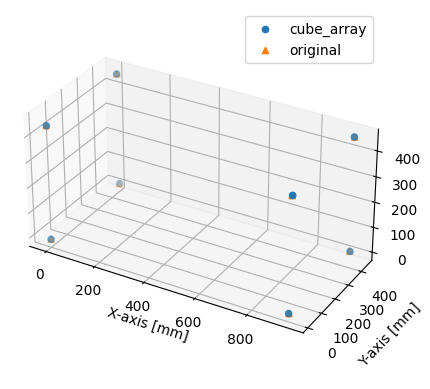

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [7]:
data_num = 0

camera_name1 = "1"
camera_name2 = "2"
camera_name3 = "3"
camera_name4 = "4"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"
cam3_dir = f"data/hirasaki_{camera_name3}_{data_num}/"
cam4_dir = f"data/hirasaki_{camera_name4}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")
cam3_position = pd.read_csv(os.path.join(cam3_dir, FileName.position_data), index_col="frame")
cam4_position = pd.read_csv(os.path.join(cam4_dir, FileName.position_data), index_col="frame")

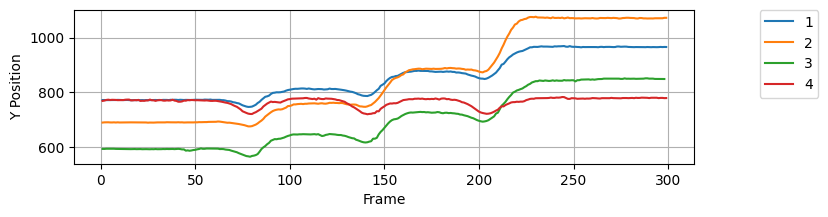

In [8]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"], label=camera_name2)
ax.plot(cam3_position.index, cam3_position[f"{name}_y"], label=camera_name3)
ax.plot(cam4_position.index, cam4_position[f"{name}_y"], label=camera_name4)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [9]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_1"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_2"].iloc[data_num]
toe_off_3 = df_camera_sync["toe_off_3"].iloc[data_num]
toe_off_4 = df_camera_sync["toe_off_4"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1
delay_3 = toe_off_3 - toe_off_1
delay_4 = toe_off_4 - toe_off_1

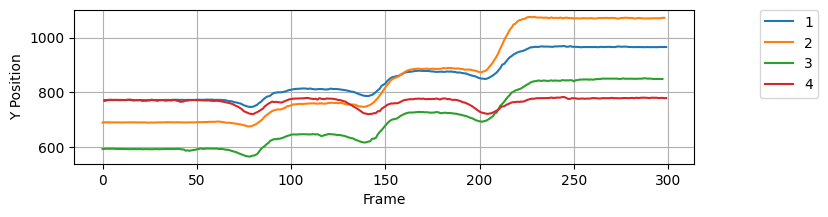

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.plot(cam3_position.index - delay_3, cam3_position[f"{name}_y"], label=camera_name3)
ax.plot(cam4_position.index - delay_4, cam4_position[f"{name}_y"], label=camera_name4)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [11]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2
cam3_position["ID"] = cam3_position.index - delay_3
cam4_position["ID"] = cam4_position.index - delay_4

In [12]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]
cam3_position = cam3_position.loc[cam3_position["ID"] > 0]
cam4_position = cam4_position.loc[cam4_position["ID"] > 0]

In [13]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)
cam3_position.set_index("ID", inplace=True, drop=True)
cam4_position.set_index("ID", inplace=True, drop=True)

In [14]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min(), cam3_position.index.min(), cam4_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max(), cam3_position.index.max(), cam4_position.index.max())

print(min_frame, max_frame)

1.0 297.0


In [15]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
cam3_pose = cam3_position.loc[frame].values.reshape(-1, 2)
cam4_pose = cam4_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose, cam3_pose, cam4_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

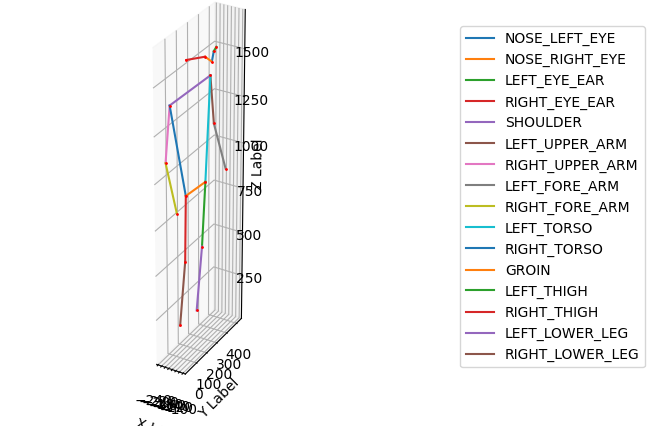

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [17]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    cam3_pose = cam3_position.loc[frame].values.reshape(-1, 2)
    cam4_pose = cam4_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose, cam3_pose, cam4_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,-97.258438,159.845255,1555.325347,-106.059603,192.663385,1592.117713,-115.962593,130.736380,1588.152709,-131.616661,...,474.258285,-202.084555,91.683940,490.601537,-236.046540,259.818703,103.077035,-238.070260,101.488877,104.295531
2,-95.710717,162.227396,1555.896515,-104.493724,195.026698,1592.653038,-115.975565,131.683813,1589.259330,-131.726178,...,468.733116,-204.365202,91.422800,484.683160,-237.302203,258.981916,100.816713,-238.118526,101.577503,102.014756
3,-94.028879,162.764964,1555.626005,-104.831299,195.342628,1591.119026,-114.673863,133.456363,1588.270335,-134.127763,...,465.282923,-206.034763,88.954908,480.865228,-237.747960,258.326770,98.103167,-240.579436,101.039700,100.510216
4,-94.439711,165.967453,1555.303114,-104.428227,195.359769,1591.351467,-115.124641,134.677213,1588.531819,-135.814944,...,465.705136,-207.421620,88.508751,481.133734,-239.502248,257.834526,97.240017,-240.026622,100.737371,99.245132
5,-95.265745,166.274604,1555.645300,-103.150809,195.921815,1592.322235,-115.961603,134.981079,1588.879845,-132.434067,...,469.016170,-204.155854,89.950445,483.740870,-238.213292,258.891743,98.580574,-238.783100,101.882900,99.976024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,4120.872302,-84.536116,1550.226175,4077.034227,-116.156322,1580.954038,4138.556830,-69.351981,1581.420085,4015.897077,...,463.908182,4012.085482,-60.308005,461.315529,3956.568711,143.427721,93.144611,3964.178560,-54.109951,98.908714
294,4120.309189,-86.006903,1550.392211,4077.417084,-116.544220,1581.618089,4140.054878,-71.148461,1579.834952,4017.401726,...,461.298174,4011.666593,-57.266821,458.476889,3956.909990,143.392904,93.206547,3964.776955,-52.916532,99.398672
295,4122.200487,-87.658688,1550.386025,4078.446946,-118.477808,1582.959770,4140.983604,-70.326201,1581.669012,4017.304039,...,464.651972,4013.249061,-57.857573,460.561196,3957.425203,144.530855,94.949578,3965.606395,-52.899632,99.333191


In [18]:
plot_3d_motion_exp(position_df/1000, output_name="camera1-4.html")